[*********************100%***********************]  1 of 1 completed
C:\Users\aminj\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.0261 - val_loss: 0.0033
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0027 - val_loss: 0.0049
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0022 - val_loss: 8.6360e-04
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 9/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0019 - val_loss: 6.6319e-04
Epoch 10/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0017 - val_loss: 7.5410e-04
Epoch 11/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 12/100
101/1

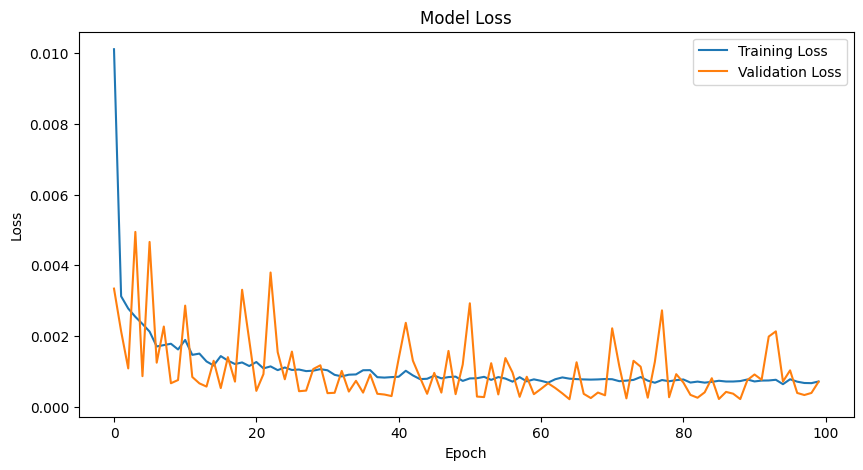

[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [120]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import matplotlib.dates as mdates
import pandas_ta as ta

# Download historical data for SPY from Yahoo Finance
spy = yf.download('SPY', start='2010-01-01', end='2024-01-01')
# === Feature Engineering with pandas-ta ===
# Add Technical Indicators
spy['RSI'] = ta.rsi(spy['Adj Close'], length=14)
spy['EMA_20'] = ta.ema(spy['Adj Close'], length=20)
spy['EMA_50'] = ta.ema(spy['Adj Close'], length=50)
spy['Volatility'] = spy['Adj Close'].rolling(20).std()


# Split data into training (2010-2020) and validation (2020-2023) sets
training_data = spy['Adj Close']['2010-01-01':'2022-12-31']
validation_data = spy['Adj Close']['2023-01-01':'2023-12-31']


# Use 'Adj Close' prices as the stock price for training
training_set = training_data.values.reshape(-1, 1)
validation_set = validation_data.values.reshape(-1, 1)

# Feature scaling using MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
validation_set_scaled = sc.transform(validation_set)

# Creating input sequences for training
def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(training_set_scaled)
X_validation, y_validation = create_sequences(validation_set_scaled)

# Features for the model
features = ['Adj Close', 'RSI', 'EMA_20', 'EMA_50', 'Volatility']

# Reshape inputs for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))

# Building the LSTM Model
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units=1))

# Compiling the LSTM Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the Model and store history
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation, y_validation))

# Plot loss and accuracy during training
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Download test data for SPY from Yahoo Finance
spy_test = yf.download('SPY', start='2023-01-01', end='2023-07-31')

# Use 'Adj Close' prices as the test data
real_stock_price = spy_test['Adj Close'].values.reshape(-1, 1)

# Preparing Test Data
dataset_total = pd.concat((spy['Adj Close'], spy_test['Adj Close']), axis=0)
inputs = dataset_total[len(dataset_total) - len(spy_test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Prepare for future predictions
future_predictions = []  # To store multi-day predictions
input_sequence = X_test[-1]  # Start with the last sequence in X_test

for _ in range(10):  # Predict 10 days into the future
    next_day_prediction = model.predict(input_sequence.reshape(1, 60, 1))
    next_day_price = sc.inverse_transform(next_day_prediction)
    future_predictions.append(next_day_price[0, 0])
    # Update the sequence with the new prediction
    input_sequence = np.append(input_sequence[1:], next_day_prediction).reshape(60, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

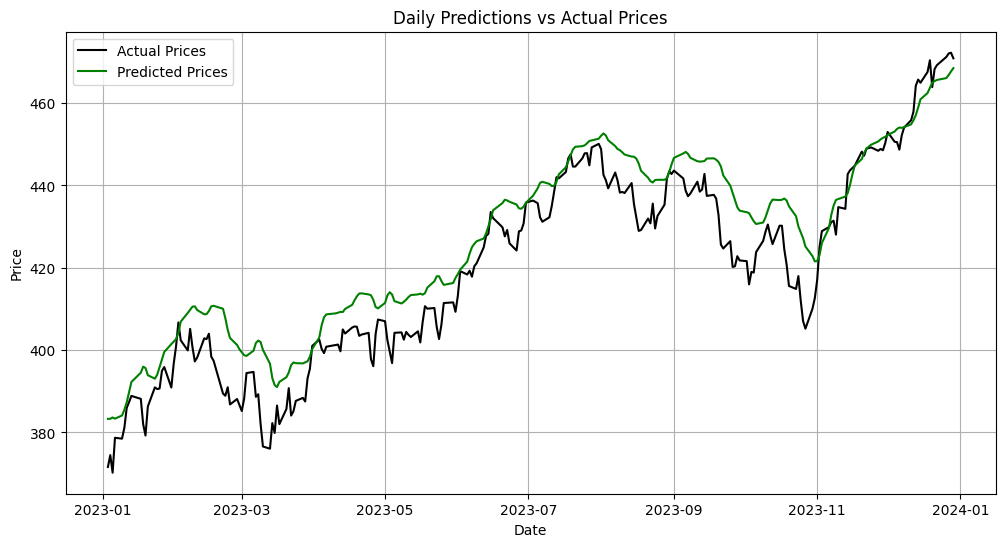

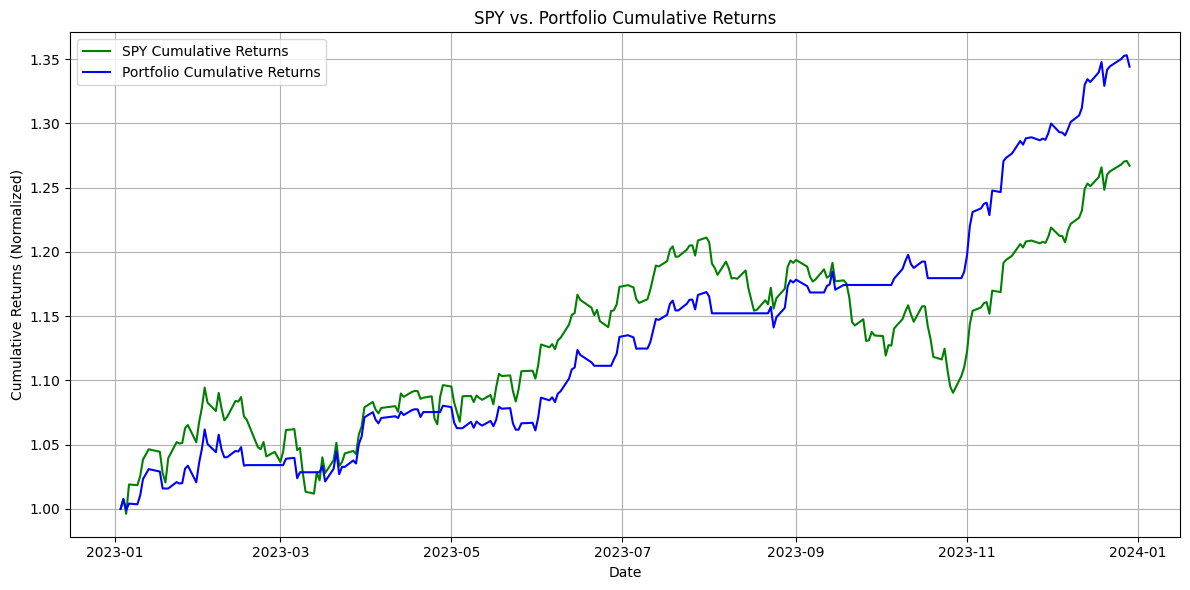

SPY Final Return: [0.26709209]
Portfolio Final Return: [0.34418125]


In [117]:
# Prepare initial sequence for the first prediction
last_sequence_2022 = training_set_scaled[-60:]  # Last 60 days of 2022 scaled data
input_sequence = last_sequence_2022  # Use this for the first day of 2023

# Initialize variables for daily predictions
daily_predictions = []  # Store predictions for each day

# Predict one day at a time for the entire validation period
for i in range(len(validation_data)):
    # Predict the next day based on the current sequence
    next_day_prediction = model.predict(input_sequence.reshape(1, 60, 1))
    next_day_price = sc.inverse_transform(next_day_prediction)  # Convert prediction back to original scale
    daily_predictions.append(next_day_price[0, 0])  # Store the prediction

    # Update the sequence with the actual price of the next day
    if i < len(validation_set_scaled):
        next_actual_price_scaled = validation_set_scaled[i, 0]  # The actual scaled price for the next day
        input_sequence = np.append(input_sequence[1:], next_actual_price_scaled).reshape(60, 1)

# Align predictions with validation data
validation_dates = validation_data.index  # Use full validation dates
validation_actual_prices = validation_data.values  # Actual prices for the validation period

# Initialize trading variables
initial_cash = 100000  # Starting cash
cash = initial_cash
shares = 0  # Positive for long, negative for short
portfolio_values = []
position_status = "neutral"  # Tracks position: "long", "short", or "neutral"
entry_price = None  # Tracks the entry price of the current position

# Trading logic: Compare daily predictions
for i in range(len(daily_predictions) - 1):
    today_predicted_price = daily_predictions[i]
    tomorrow_predicted_price = daily_predictions[i + 1]
    today_actual_price = validation_actual_prices[i]

    # === Open or Close Positions ===
    if position_status == "neutral":
        # Buy signal: Tomorrow's predicted price > Today's predicted price AND Tomorrow's predicted price > Today's actual price
        if tomorrow_predicted_price > today_predicted_price and tomorrow_predicted_price > today_actual_price:
            print(f"Buy Signal Triggered on Day {i}. {position_status}")
            shares_to_buy = (cash+500) / today_actual_price  # Buy as many shares as possible
            cash = 0  # Use all cash
            shares += shares_to_buy
            position_status = "long"
            entry_price = today_actual_price

        # Sell/Short signal: Tomorrow's predicted price < Today's predicted price AND Tomorrow's predicted price < Today's actual price
        elif tomorrow_predicted_price < today_predicted_price and tomorrow_predicted_price < today_actual_price:
            print(f"Sell Signal Triggered on Day {i}. {position_status}")
            shares_to_short = (cash - 500) / today_actual_price  # Short as many shares as possible (borrowed shares)
            cash += shares_to_short * today_actual_price  # Receive cash for shorting
            shares -= shares_to_short  # Negative shares indicate short position
            position_status = "short"
            entry_price = today_actual_price

    elif position_status == "long":
        # Exit long position if the predicted price no longer supports the buy signal, and go short if conditions allow
        if tomorrow_predicted_price <= today_predicted_price:
            print(f"Exit Long Position on Day {i}. {position_status}")
            cash += 300 + shares * today_actual_price  # Sell all shares
            shares = 0
            position_status = "neutral"
            entry_price = None

            # Immediately check if we should go short after closing the long position
            if tomorrow_predicted_price < today_predicted_price and tomorrow_predicted_price < today_actual_price:
                print(f"Sell Signal Triggered on Day {i} after Closing Long.")
                shares_to_short = cash / today_actual_price  # Short as many shares as possible (borrowed shares)
                cash += shares_to_short * today_actual_price  # Receive cash for shorting
                shares -= shares_to_short  # Negative shares indicate short position
                position_status = "short"
                entry_price = today_actual_price

    elif position_status == "short":
        # Exit short position if the predicted price no longer supports the sell signal, and go long if conditions allow
        if tomorrow_predicted_price >= today_predicted_price:
            print(f"Exit Short Position on Day {i}. {position_status}")
            cash -= abs(shares) * today_actual_price  # Buy back at the current price
            shares = 0
            position_status = "neutral"
            entry_price = None

            # Immediately check if we should go long after closing the short position
            if tomorrow_predicted_price > today_predicted_price and tomorrow_predicted_price > today_actual_price:
                print(f"Buy Signal Triggered on Day {i} after Closing Short.")
                shares_to_buy = (cash + 200) / today_actual_price  # Buy as many shares as possible
                cash = 0  # Use all cash
                shares += shares_to_buy
                position_status = "long"
                entry_price = today_actual_price

    # Calculate the current portfolio value after any changes
    if shares >= 0:  # Long position or no position
        portfolio_value = 500 + cash + shares * today_actual_price
    else:  # Short position
        portfolio_value = 500 + cash - abs(shares) * today_actual_price
    portfolio_values.append(portfolio_value)

# Final portfolio value
if shares >= 0:
    final_portfolio_value = cash + shares * validation_actual_prices[-1]
else:
    final_portfolio_value = cash - abs(shares) * validation_actual_prices[-1]
portfolio_values.append(final_portfolio_value)

# Ensure final_portfolio_value is a scalar
if isinstance(final_portfolio_value, np.ndarray):
    final_portfolio_value = final_portfolio_value.item()

# Calculate SPY returns for comparison
spy_initial_price = validation_actual_prices[0]
spy_cumulative_returns = [(price / spy_initial_price) for price in validation_actual_prices]

# Align validation dates with portfolio values
validation_dates = validation_dates[:len(portfolio_values)]

# Calculate cumulative portfolio returns
portfolio_initial_value = portfolio_values[0]
portfolio_cumulative_returns = [value / portfolio_initial_value for value in portfolio_values]

# Plot daily predictions vs. actual prices
plt.figure(figsize=(12, 6))
plt.plot(validation_dates, validation_actual_prices[:len(validation_dates)], label='Actual Prices', color='black')
plt.plot(validation_dates, daily_predictions[:len(validation_dates)], label='Predicted Prices', color='green')
plt.title('Daily Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plotting SPY and Portfolio Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(validation_dates, spy_cumulative_returns[:len(validation_dates)], label="SPY Cumulative Returns", color="green")
plt.plot(validation_dates, portfolio_cumulative_returns, label="Portfolio Cumulative Returns", color="blue")
plt.title("SPY vs. Portfolio Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (Normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print Final Returns for Comparison
spy_final_return = spy_cumulative_returns[-1] - 1  # Subtract 1 to get percentage return
portfolio_final_return = portfolio_cumulative_returns[-1] - 1  # Subtract 1 to get percentage return

print(f"SPY Final Return: {spy_final_return:}")
print(f"Portfolio Final Return: {portfolio_final_return:}")
